In [1]:
import json
import os
import re

In [3]:
with open("../data/chatbot-arena-spoken-1turn-english-difference-voices.json") as f:
    raw_data = json.load(f)
gts = []
gt_mapping = {
    'model_a': 'A',
    'model_b': 'B',
    'tie': 'C',
    'tie (bothbad)': 'C'
}
for x in raw_data:
    gts.append(gt_mapping[x['winner']])
print("len:", len(gts))

len: 7824


In [4]:
def read_jsonl(file_path):
    data = []
    # Open and read the file line by line
    with open(file_path, 'r') as file:
        for line in file:
            # Parse each line as a JSON object
            json_obj = json.loads(line.strip())
            data.append(json_obj)
    print("len:", len(data))
    return data

In [5]:
def process_output(data):
    labels = []
    for x in data:
        response = x['response']
        response = response[-20:]
        labels += [extract_abc(response)]
    calculate_percentage(labels)
    return labels

def calculate_correciness(labels, gts, reverse=False):
    # assert len(labels) == len(gts)
    labels = labels[:len(gts)]
    correct, incorrect = 0, 0
    correct_AB, incorrect_AB = 0, 0
    for label, gt in zip(labels, gts):
        if reverse == True:
            if gt == 'A': 
                gt = 'B'
            elif gt == 'B': 
                gt = 'A'
        if label == gt:
            correct += 1
        else:
            incorrect += 1

        if label == 'A' or label == 'B':
            if label == gt:
                correct_AB += 1
            else:
                incorrect_AB += 1    
    print("correct:   {:.2f}%".format(correct/(correct+incorrect)*100))
    print("incorrect: {:.2f}%".format(incorrect/(correct+incorrect)*100))
    # print("correct_AB:   {:.2f}%".format(correct_AB/(correct_AB+incorrect_AB)*100))
    # print("incorrect_AB: {:.2f}%".format(incorrect_AB/(correct_AB+incorrect_AB)*100))

In [6]:
def extract_abc(text):
    pattern = r'\[\[(A|B|C)\]\]'
    
    # Search for the match
    match = re.search(pattern, text)
    
    if match:
        result = match.group(1)
        # print(f"Extracted value: {result}")
    else:
        result = "D"
    return result 

In [7]:
def calculate_percentage(arr):
    # Get the total number of items
    total_count = len(arr)
    
    # Create a dictionary to store counts of each unique item
    item_counts = {'A': 0, 'B': 0, 'C': 0, 'D': 0}
    
    for item in arr:
        item_counts[item] = item_counts.get(item, 0) + 1
    
    # Calculate percentages and store them in a dictionary
    percentages = {item: (count / total_count) * 100 for item, count in item_counts.items()}
    
    # Display the result
    print("---------------")
    for item, percentage in percentages.items():
        print(f"{item}: {percentage:.2f}%")
    print("---------------")

In [8]:
def measure_bias(preds_ab, preds_ba):
    n = min(len(preds_ab), len(preds_ba))
    preds_ab = preds_ab[:n]
    preds_ba = preds_ba[:n]
    biasA, biasB, consistentAB, consistentCC, other = 0, 0, 0, 0, 0
    for pred_ab, pred_ba in zip(preds_ab, preds_ba):
        if pred_ab == "A" and pred_ba == "A":
            biasA += 1
        elif pred_ab == "B" and pred_ba == "B":
            biasB += 1
        elif pred_ab == "A" and pred_ba == "B":
            consistentAB += 1  
        elif pred_ab == "B" and pred_ba == "A":
            consistentAB += 1
        elif pred_ab == "C" and pred_ba == "C":
            consistentCC += 1
        else:
            other += 1
    total = biasA + biasB + consistentAB # + consistentCC + other
    print("consistentAB: {:.2f}".format(consistentAB/total*100)) 
    # print("consistentCC: {:.2f}".format(consistentCC/total*100)) 
    print("biasA:      {:.2f}".format(biasA/total*100)) 
    print("biasB:      {:.2f}".format(biasB/total*100)) 
    # print("other:      {:.2f}".format(other/total*100)) 

In [10]:
text_text = process_output(read_jsonl("../experiments/chatbot-arena-7824/text-text-gemini2.5flash.jsonl"))
calculate_correciness(text_text, gts)
print("############################")
text_text_BA = process_output(read_jsonl("../experiments/chatbot-arena-7824/text-text-gemini2.5flash_BA.jsonl"))
calculate_correciness(text_text_BA, gts, reverse=True)
print("############################")
measure_bias(text_text, text_text_BA)

len: 7824
---------------
A: 46.97%
B: 43.43%
C: 9.22%
D: 0.38%
---------------
correct:   56.71%
incorrect: 43.29%
############################
len: 7824
---------------
A: 46.93%
B: 43.70%
C: 8.93%
D: 0.43%
---------------
correct:   56.81%
incorrect: 43.19%
############################
consistentAB: 88.24
biasA:      7.44
biasB:      4.32


In [11]:
0.5*(56.71+56.81)

56.760000000000005

In [13]:
audio_text = process_output(read_jsonl("../experiments/chatbot-arena-7824/audio-text-gemini2.5flash.jsonl"))
calculate_correciness(audio_text, gts)
print("############################")
audio_text_BA = process_output(read_jsonl("../experiments/chatbot-arena-7824/audio-text-gemini2.5flash_BA.jsonl"))
calculate_correciness(audio_text_BA, gts, reverse=True)
print("############################")
measure_bias(audio_text, audio_text_BA)

len: 7824
---------------
A: 46.56%
B: 44.35%
C: 8.64%
D: 0.45%
---------------
correct:   56.25%
incorrect: 43.75%
############################
len: 7824
---------------
A: 46.60%
B: 44.63%
C: 8.35%
D: 0.42%
---------------
correct:   55.96%
incorrect: 44.04%
############################
consistentAB: 87.39
biasA:      7.32
biasB:      5.30


In [14]:
0.5*(56.25+55.96)

56.105000000000004

In [15]:
audio_audio = process_output(read_jsonl("../experiments/chatbot-arena-7824/audio-audio-gemini2.5flash.jsonl"))
calculate_correciness(audio_audio, gts)
print("############################")
audio_audio_BA = process_output(read_jsonl("../experiments/chatbot-arena-7824/audio-audio-gemini2.5flash_BA.jsonl"))
calculate_correciness(audio_audio_BA, gts, reverse=True)
print("############################")
measure_bias(audio_audio, audio_audio_BA)

len: 7824
---------------
A: 45.60%
B: 45.79%
C: 8.14%
D: 0.46%
---------------
correct:   56.11%
incorrect: 43.89%
############################
len: 7824
---------------
A: 45.07%
B: 46.00%
C: 8.44%
D: 0.50%
---------------
correct:   56.40%
incorrect: 43.60%
############################
consistentAB: 86.38
biasA:      6.59
biasB:      7.03


In [16]:
0.5*(56.11+56.40)

56.254999999999995

In [17]:
asr_asr = process_output(read_jsonl("../experiments/chatbot-arena-7824/wpbase-wpbase-gemini2.5flash.jsonl"))
calculate_correciness(asr_asr, gts)
print("############################")
asr_asr_BA = process_output(read_jsonl("../experiments/chatbot-arena-7824/wpbase-wpbase-gemini2.5flash_BA.jsonl"))
calculate_correciness(asr_asr_BA, gts, reverse=True)
print("############################")
measure_bias(asr_asr, asr_asr_BA)

len: 7824
---------------
A: 46.26%
B: 42.88%
C: 10.42%
D: 0.45%
---------------
correct:   53.02%
incorrect: 46.98%
############################
len: 7824
---------------
A: 46.50%
B: 42.54%
C: 10.61%
D: 0.36%
---------------
correct:   53.17%
incorrect: 46.83%
############################
consistentAB: 86.96
biasA:      8.40
biasB:      4.64


In [18]:
0.5*(53.02+53.17)

53.095

In [19]:
calculate_correciness(text_text, audio_text)

correct:   84.30%
incorrect: 15.70%


In [20]:
calculate_correciness(text_text, audio_audio)

correct:   79.44%
incorrect: 20.56%


In [21]:
calculate_correciness(audio_text, audio_audio)

correct:   81.34%
incorrect: 18.66%


## System-level Correlation

In [22]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [23]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, pvalue = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")
    print("pvalue Spearman: {:.2e}".format(pvalue))

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('Human Judge (Win Rate)')
    plt.ylabel('LLM Judge (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
with open("../data/chatbot-arena-spoken-1turn-english-difference-voices.json") as f:
    raw_data = json.load(f)

In [25]:
uniq_systems = set([x['model_a'] for x in raw_data] + [x['model_b'] for x in raw_data])
uniq_systems = list(uniq_systems)
len(uniq_systems)

20

In [26]:
def system_level_analysis(path_ab, path_ba):
    data_ab = read_jsonl(path_ab)
    data_ba = read_jsonl(path_ba)
    n = min([len(data_ab), len(data_ba), len(raw_data)])
    print("n:", n)
    
    system_preds = {k: [] for k in uniq_systems}
    system_gts = {k: [] for k in uniq_systems}
    
    for i in range(n):
        x = raw_data[i]
        ab = data_ab[i]
        ba = data_ba[i]
        modelA, modelB = x['model_a'], x['model_b']
        
        label_ab = extract_abc(ab['response'][-20:])
        if label_ab == 'A':
            system_preds[modelA].append(1.0)
            system_preds[modelB].append(0.0)
        elif label_ab == 'B':
            system_preds[modelB].append(1.0)
            system_preds[modelA].append(0.0)
        else:
            system_preds[modelB].append(0.5)
            system_preds[modelA].append(0.5)
            
        label_ba = extract_abc(ba['response'][-20:])
        if label_ba == 'A':
            system_preds[modelB].append(1.0)
            system_preds[modelA].append(0.0)
        elif label_ba == 'B':
            system_preds[modelA].append(1.0)
            system_preds[modelB].append(0.0)
        else:
            system_preds[modelB].append(0.5)
            system_preds[modelA].append(0.5)
    
        if x['winner'] == 'model_a':
            system_gts[modelA].append(1.0)
            system_gts[modelB].append(0.0)
        elif x['winner'] == 'model_b':
            system_gts[modelB].append(1.0)
            system_gts[modelA].append(0.0)
        else:
            system_gts[modelA].append(0.5)
            system_gts[modelB].append(0.5)
            
    system_level_pred, system_level_gts = [], []
    for system, pred in system_preds.items():
        if len(pred) == 0:
            continue
        gts = system_gts[system]
        assert len(pred) == 2*len(gts)
        assert math.isnan(np.mean(pred)) is False
        system_level_pred.append(np.mean(pred))
        system_level_gts.append(np.mean(gts))
    analyze_correlation_and_plot(system_level_gts, system_level_pred)

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.970
Spearman Correlation: 0.974
pvalue Spearman: 4.04e-13


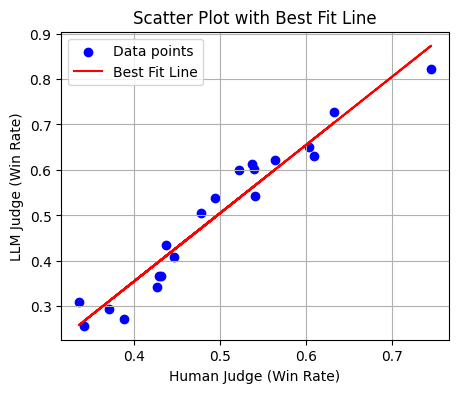

In [27]:
system_level_analysis("../experiments/chatbot-arena-7824/text-text-gemini2.5flash.jsonl", "../experiments/chatbot-arena-7824/text-text-gemini2.5flash_BA.jsonl")

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.971
Spearman Correlation: 0.973
pvalue Spearman: 6.71e-13


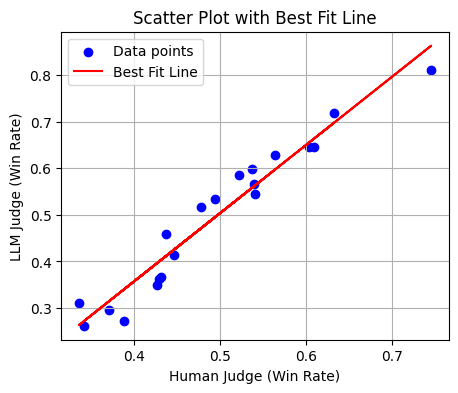

In [28]:
system_level_analysis("../experiments/chatbot-arena-7824/audio-text-gemini2.5flash.jsonl", "../experiments/chatbot-arena-7824/audio-text-gemini2.5flash_BA.jsonl")

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.975
Spearman Correlation: 0.977
pvalue Spearman: 1.32e-13


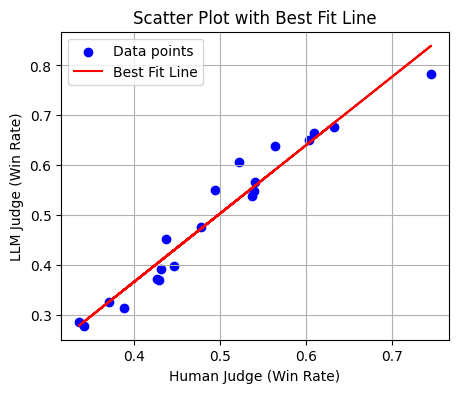

In [29]:
system_level_analysis("../experiments/chatbot-arena-7824/audio-audio-gemini2.5flash.jsonl", "../experiments/chatbot-arena-7824/audio-audio-gemini2.5flash_BA.jsonl")

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.953
Spearman Correlation: 0.920
pvalue Spearman: 9.20e-09


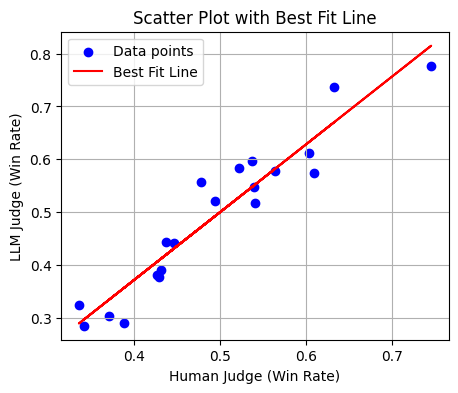

In [30]:
system_level_analysis("../experiments/chatbot-arena-7824/wpbase-wpbase-gemini2.5flash.jsonl", "../experiments/chatbot-arena-7824/wpbase-wpbase-gemini2.5flash_BA.jsonl")